In [ ]:
%reset -f

In [2]:
# import session
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import neighbors, linear_model, metrics, tree, cross_validation, svm
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, StratifiedKFold as KFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesRegressor as XTR
from sklearn.ensemble import RandomForestClassifier as RF


/opt/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Preparing data for classification

### 1.1 Stage1 data

In [121]:
df_feature = pd.read_csv("./feature_matrix_model1_stage1.csv")
df_feature['id'] = df_feature['Unnamed: 0'].apply(lambda x: x.split('.')[0])
# print (df_feature.shape)

df_labels_1 =pd.read_csv('/home/lin/data/stage1_labels.csv')
# print (df_labels_1.shape)

df_labels_2 = pd.read_csv('/home/lin/data/stage1_solution.csv')
df_labels_2 = df_labels_2.drop(['Usage'],1)
# print (df_labels_2.shape)

df_labels = df_labels_1.append(df_labels_2)
print ("Total %d labels"%df_labels.shape[0])

df = pd.merge(left=df_feature, right=df_labels,how='outer',on='id').dropna()
df = df.drop(['Unnamed: 0'],1)
print (df.shape)
df.head()

Total 1595 labels
(1434, 16)


,max_malig,max_spiculation,max_lobulation,max_diameter,xsd_malig,xsd_spiculation,xmax_lobulation,xsd_diameter,loc_from_malig_x,loc_from_malig_y,loc_from_malig_z,std_locs_x,std_locs_y,std_locs_z,id,cancer
0,0.697503,0.335968,0.385324,0.339156,0.148894,0.089260,0.385324,0.085551,0.753571,0.528571,0.434028,0.244258,0.163056,0.242655,d777a77cc7a2ec2f1eed68799cc9075c,1
1,0.666373,0.345718,0.391515,0.359679,0.148370,0.082181,0.391515,0.078761,0.088889,0.416667,0.304487,0.243736,0.159560,0.216008,1631637f08f27347e8f23d7a0e18c100,0
2,0.701259,0.347774,0.394380,0.360565,0.159877,0.084858,0.394380,0.079833,0.706061,0.418182,0.799363,0.231711,0.155614,0.217998,9065f2b133129c5747d42db18a424749,1
3,0.690341,0.343430,0.400079,0.354308,0.147548,0.088106,0.400079,0.085576,0.315789,0.112281,0.555556,0.233297,0.183184,0.207843,e3a9a6f8d21c6c459728066bcf18c615,0
4,0.726764,0.341739,0.396748,0.356204,0.147422,0.088995,0.396748,0.086762,0.885294,0.582353,0.373563,0.249184,0.183342,0.214586,f39a1e54d79731e4417aa8159d19b7d4,0


## 2. Data exploration

### 2.1 Basic estadistics

+ How many patients do we have for training-test? --> 1257
+ How many cancer patients? --> 315
+ What percentage is the cancer patient? --> 25%


In [36]:
print ("data frame shape", df.shape)
print ("number of cancer patient:",df['cancer'].sum() )
print ("how un-balance is the data:", df['cancer'].sum()/df.shape[0])

data frame shape (1434, 16)
number of cancer patient: 363
how un-balance is the data: 0.25313807531380755


### 2.2 Cancer patient v.s. Non-cancer patients

In [70]:
df_cancer = df.loc[df['cancer'] == 1]
print (df_cancer.shape)
df_cancer.head()

(363, 16)


,max_malig,max_spiculation,max_lobulation,max_diameter,xsd_malig,xsd_spiculation,xmax_lobulation,xsd_diameter,loc_from_malig_x,loc_from_malig_y,loc_from_malig_z,std_locs_x,std_locs_y,std_locs_z,id,cancer
0,0.697503,0.335968,0.385324,0.339156,0.148894,0.089260,0.385324,0.085551,0.753571,0.528571,0.434028,0.244258,0.163056,0.242655,d777a77cc7a2ec2f1eed68799cc9075c,1
2,0.701259,0.347774,0.394380,0.360565,0.159877,0.084858,0.394380,0.079833,0.706061,0.418182,0.799363,0.231711,0.155614,0.217998,9065f2b133129c5747d42db18a424749,1
6,0.668319,0.338826,0.384684,0.337507,0.154942,0.091774,0.384684,0.087845,0.221429,0.385714,0.613475,0.212833,0.155433,0.220319,7c2b72f9e0f5649c22902292febdc89f,1
10,0.659050,0.350864,0.396342,0.361564,0.149278,0.087901,0.396342,0.083719,0.093023,0.180233,0.553571,0.246453,0.172813,0.243043,f5717f7cbc08d8bd942cd4c1128e3339,1
13,0.644114,0.341161,0.386432,0.342413,0.152086,0.093578,0.386432,0.091503,0.281553,0.391586,0.602941,0.204743,0.144383,0.161236,882107a204c302e27628f85522baea49,1


In [71]:
df_no_cancer = df.loc[df['cancer'] == 0]
print (df_no_cancer.shape)
df_no_cancer.head()

(1071, 16)


,max_malig,max_spiculation,max_lobulation,max_diameter,xsd_malig,xsd_spiculation,xmax_lobulation,xsd_diameter,loc_from_malig_x,loc_from_malig_y,loc_from_malig_z,std_locs_x,std_locs_y,std_locs_z,id,cancer
1,0.666373,0.345718,0.391515,0.359679,0.148370,0.082181,0.391515,0.078761,0.088889,0.416667,0.304487,0.243736,0.159560,0.216008,1631637f08f27347e8f23d7a0e18c100,0
3,0.690341,0.343430,0.400079,0.354308,0.147548,0.088106,0.400079,0.085576,0.315789,0.112281,0.555556,0.233297,0.183184,0.207843,e3a9a6f8d21c6c459728066bcf18c615,0
4,0.726764,0.341739,0.396748,0.356204,0.147422,0.088995,0.396748,0.086762,0.885294,0.582353,0.373563,0.249184,0.183342,0.214586,f39a1e54d79731e4417aa8159d19b7d4,0
5,0.691301,0.342192,0.395080,0.358410,0.161766,0.087251,0.395080,0.083102,0.574286,0.574286,0.486301,0.219889,0.184321,0.200701,8987df2216ae2ab1a907d52bc9dc540d,0
7,0.665821,0.336849,0.386759,0.351551,0.157453,0.089670,0.386759,0.085031,0.274011,0.324859,0.735593,0.234608,0.177474,0.225888,e60d99ea9648e1ce859eb0b386365e26,0


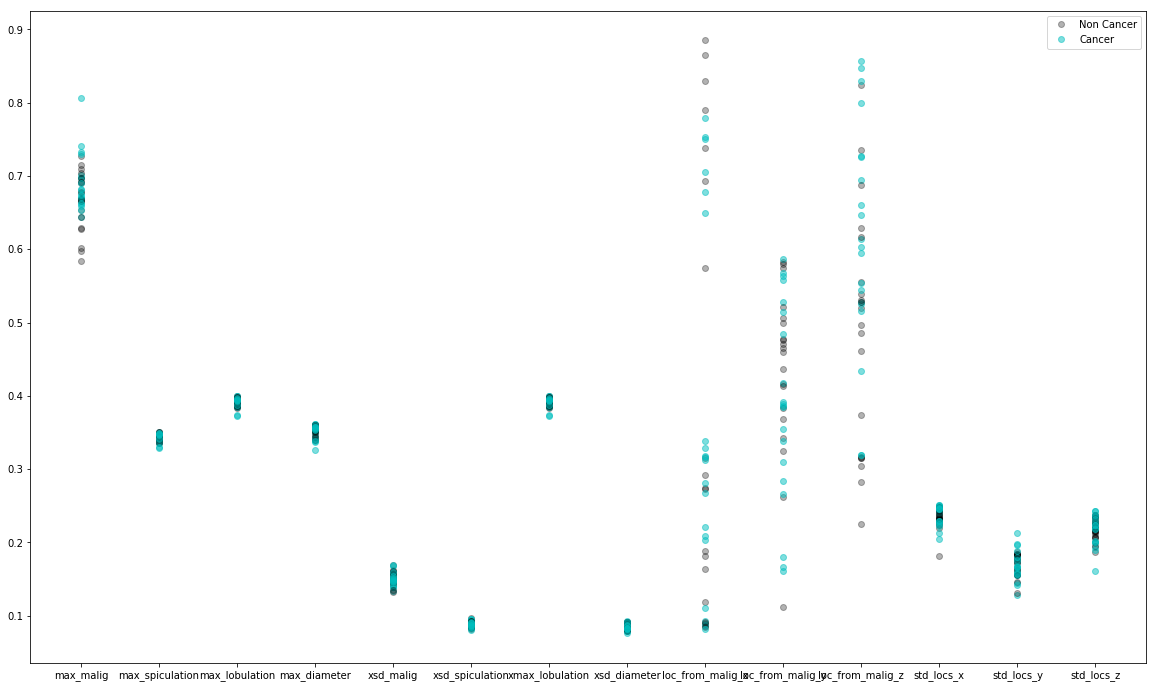

In [109]:
# df_no_cancer.reset_index(inplace=True, drop=True)
fig, ax = plt.subplots(figsize=[20,12])

cancerCount=0
nonCancerCount=0

for patient in range(100):
    if df.iloc[patient].cancer==0:
        if nonCancerCount<20:
            nonCancerCount+=1
            line1, = plt.plot(np.arange(14), df.iloc[patient][:-2],'ok',alpha=0.3,label='Non Cancer')
    else:
        if cancerCount<20:
            cancerCount+=1
            line2, = plt.plot(np.arange(14), df.iloc[patient][:-2],'oc',alpha=0.5,label='Cancer')

plt.legend((line1,line2),('Non Cancer','Cancer'))
plt.xticks([x for x in range(14)])
ax.set_xticklabels(df.columns[:-2]);

/opt/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:5749: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


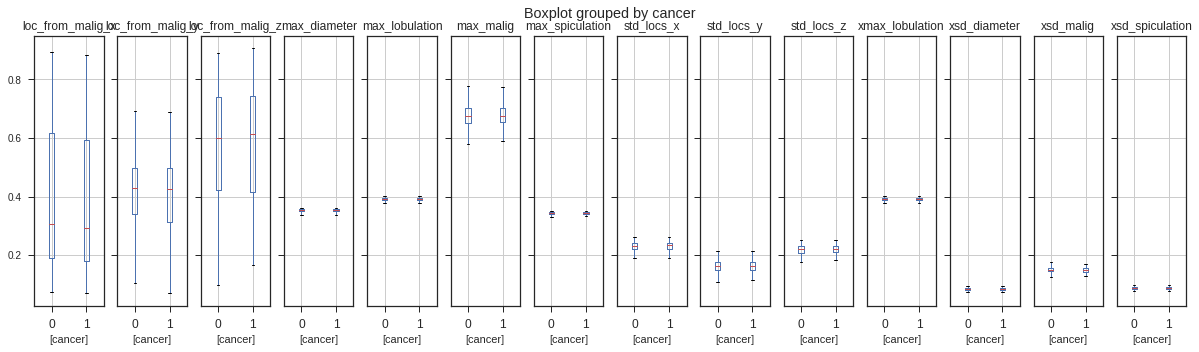

In [130]:
import seaborn
seaborn.set(style="ticks")
fig, axes = plt.subplots(ncols=14, figsize=(20, 5), sharey=True)
df.query("cancer in [0, 1]").boxplot(by='cancer', return_type='axes', ax=axes);

#### 2.2.1 Mean

Not surprisely, as the box plot above showed, they are extremly similar!! 

In [73]:
df_cancer_mean = df.loc[df['cancer'] == 1].mean()
df_no_cancer_mean = df.loc[df['cancer'] == 0].mean()
print (df_cancer_mean-df_no_cancer_mean)
# print (df_cancer_mean)

max_malig          -0.000556
max_spiculation     0.000453
max_lobulation      0.000310
max_diameter        0.000197
xsd_malig          -0.000839
xsd_spiculation    -0.000009
xmax_lobulation     0.000310
xsd_diameter       -0.000004
loc_from_malig_x   -0.017301
loc_from_malig_y   -0.011904
loc_from_malig_z    0.006386
std_locs_x          0.000371
std_locs_y          0.000825
std_locs_z          0.001998
cancer              1.000000
dtype: float64


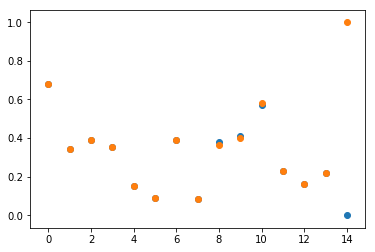

In [58]:
plt.scatter(np.arange(15),df_no_cancer_mean)
plt.scatter(np.arange(15),df_cancer_mean)

## 3. Metrics

### 3.1 Confusion matrix

<div class = "alert alert-info">
**Unbalanced datasets**
<p>
In cancer detection because the cost of missing one patient in a trial is very large, we want the predictor to have very large recall/sensitivity (we do not accept false negatives) though it means accepting more false positives. These false positives can be discarded in subsequent tests. 

<p>
$$\text{sensitivity (recall) }=\frac{\text{TP}}{\text{Real Positives}}=\frac{\text{TP}}{\text{TP}+\text{FN}}$$


</div>

Although accuracy is the most normal metric for evaluating classifiers, there are cases when the business value of correctly predicting elements from one class is different from the value for the prediction of elements of another class. In those cases, accuracy is not a good performance metric and more detailed analysis is needed. The **confusion matrix** enables us to define different metrics considering such scenarios. The confusion matrix considers the concepts of the classifier outcome and the actual ground truth or gold standard. In a binary problem, there are four possible cases: 


+ *True positives (TP):* When the classifier predicts a sample as positive and it really is positive.
+ *False positives (FP):* When the classifier predicts a sample as positive but in fact it is negative.
+ *True negatives (TN):* When the classifier predicts a sample as negative and it really is negative.
+ *False negatives (FN):* When the classifier predicts a sample as negative but in fact it is positive.


We can summarize this information in a matrix, namely the confusion matrix, as follows:

<img src = "https://i.stack.imgur.com/OW5Lt.jpg" width = 400px>

### 3.2 Evaluation: Logloss

https://www.kaggle.com/c/data-science-bowl-2017#evaluation

$$
\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right],
$$

where

+ n is the number of patients in the test set
+ $\hat{y}_i $ is the predicted probability of the image belonging to a patient with cancer
+ $ y_i $ is 1 if the diagnosis is cancer, 0 otherwise
+ $ log()$ is the natural (base e) logarithm

Note: the actual submitted predicted probabilities are replaced with $(max(min(p,1-10^{-15}),10^{-15}))$ . A smaller log loss is better.

## 4. Feature selection,  classification, and evaluation

### 4.1 Feature selection 

In [156]:
## Feature selection ##
x_cols = df.drop(['id', 'cancer'],1).columns  # using all the features
# x_cols=['max_malig','max_spiculation','max_lobulation','max_diameter','xsd_malig', 'xsd_spiculation', 'xmax_lobulation','xsd_diameter']
X = df.loc[:][x_cols].values
y = df.loc[:]['cancer'].values

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 1434 observations and 14 features
Unique target labels: [0 1]


### 4.2 Clssification

### 4.2.1 Logistic regression (LR) with ExtraTreesRegressor (XTR)

In [111]:
class SlightlyNonlinearClassification(BaseEstimator):

    def __init__(self,C=10,step_size=0.7):
        self.step_size = step_size
        self.C = C

    def fit(self, X, y):
        lr = LogisticRegression(C=self.C,penalty='l1')
        lr_preds = cross_val_predict(lr, X, y, cv=50, method='predict_proba')[:,1]
        lr.fit(X,y)
        xtr = XTR(n_estimators=500, min_samples_leaf=20, max_features=.8).fit(X, y - lr_preds)
        self.lr = lr
        self.xtr = xtr

        return self

    def predict_proba(self, X):
        base = self.lr.predict_proba(X)
        base[:,1] += self.step_size * self.xtr.predict(X)
        base[:,0] = 1 - base[:,1]
        return np.clip(base, 1e-3, 1-1e-3)

    def predict(self, X):
        return self.predict_proba(X)

(1434,)
logloss 0.57234386471


(array([  24.,  122.,  280.,  395.,  333.,  188.,   59.,   25.,    7.,    1.]),
 array([ 0.11377417,  0.15047154,  0.1871689 ,  0.22386626,  0.26056362,
         0.29726098,  0.33395835,  0.37065571,  0.40735307,  0.44405043,
         0.48074779]),
 <a list of 10 Patch objects>)

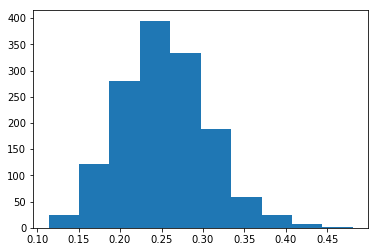

In [113]:
x_cols = df.drop(['id', 'cancer'],1).columns  # using all the features
X = df.loc[:][x_cols].values
y = df.loc[:]['cancer'].values

X = StandardScaler().fit_transform(X)
lr = SlightlyNonlinearClassification(C=1000, step_size=0.9)
Yh = cross_val_predict(lr, X, y, cv=10, method='predict_proba',n_jobs=-1)[:,1]

print (Yh.shape)
print ("logloss",log_loss(y, Yh) )
plt.hist(Yh)

In [ ]:
for threshold in range(0.15, 0.5, 0.05):
    if 

In [ ]:
x_cols = df.drop(['id', 'cancer'],1).columns  # using all the features
X = df.loc[:][x_cols].values
y = df.loc[:]['cancer'].values

cv = cross_validation.KFold(X.shape[0],n_folds = 20,random_state=42)
y_pred = y * 0
y_pred_prob = np.zeros(len(y))
for train, test in cv:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], y[train], y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = SlightlyNonlinearClassification(C=1000, step_size=0.9)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
    y_pred_prob[test] = clf.predict_proba(X_test)[:,1]
    
print ('Logistic Regression')

conf_mat = confusion_matrix(y,y_pred)
D = conf_mat[0][0]    # TP
B = conf_mat[0][1]    # FP
C = conf_mat[1][0]    # FN
A = conf_mat[1][1]    # TN

print ("confusion_matrix for test set: \n", conf_mat)
print (classification_report(y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",log_loss(y, y_pred_prob))
print ("Specificity: ", D/(B+D))
print ("Recall: ", A/(A+C))
print ("Accuracy: ", (A+D)/(A+B+C+D))

### 4.2.2 LogisticRegression

In [117]:
# LogisticRegression

x_cols = df.drop(['id', 'cancer'],1).columns  # using all the features
X = df.loc[:][x_cols].values
y = df.loc[:]['cancer'].values

cv = cross_validation.KFold(X.shape[0],n_folds = 20,random_state=42)
y_pred = y * 0
y_pred_prob = np.zeros(len(y))
for train, test in cv:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], y[train], y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf = linear_model.LogisticRegression(class_weight={0:0.22,1:0.78},penalty='l1')
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
    y_pred_prob[test] = clf.predict_proba(X_test)[:,1]
    
print ('Logistic Regression')

conf_mat = confusion_matrix(y,y_pred)
D = conf_mat[0][0]    # TP
B = conf_mat[0][1]    # FP
C = conf_mat[1][0]    # FN
A = conf_mat[1][1]    # TN

print ("confusion_matrix for test set: \n", conf_mat)
print (classification_report(y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",log_loss(y, y_pred_prob))
print ("Specificity: ", D/(B+D))
print ("Recall: ", A/(A+C))
print ("Accuracy: ", (A+D)/(A+B+C+D))

Logistic Regression
confusion_matrix for test set: 
 [[196 875]
 [ 74 289]]
             precision    recall  f1-score   support

  No Cancer       0.73      0.18      0.29      1071
     Cancer       0.25      0.80      0.38       363

avg / total       0.61      0.34      0.31      1434

logloss 0.741827531353
Specificity:  0.183006535948
Recall:  0.796143250689
Accuracy:  0.338214783821


### 4.2.3 logistic regression with tuned parameter

+ Cross-validate, 20 folders
+ with class weight
+ l1 penalty
+ grid search for the value of C, i.e.,Inverse of regularization strength

In [131]:
cv = cross_validation.KFold(X.shape[0],n_folds = 20,random_state=42)

# lr = linear_model.LogisticRegression(penalty='l1', class_weight='balanced')
Cs = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.5]
parameters = {'C': Cs} 

acc = np.zeros((20,))
yhat = y.copy()
y_pred_prob = np.zeros(len(y))

for train_index, test_index in cv:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf = linear_model.LogisticRegression(penalty='l1', class_weight='balanced')
    # We can change the scoring "average_precision", "recall", "f1"
    grd = GridSearchCV(clf, parameters)  
    grd.fit(X_train,y_train.ravel())
   
    yhat[test_index] = grd.predict(X_test)
    y_pred_prob[test_index] = grd.predict_proba(X_test)[:,1]
    
    conf_mat = confusion_matrix(y,y_pred)
    D = conf_mat[0][0]    # TP
    B = conf_mat[0][1]    # FP
    C = conf_mat[1][0]    # FN
    A = conf_mat[1][1]    # TN
    
# print ('Mean accuracy: '+ str(np.mean(acc)))
print ("\nconfusion_matrix from sklearn: \n", conf_mat)
print (classification_report(y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",log_loss(y, y_pred_prob))

print ("Specificity: ", D/(B+D))
print ("Recall: ", A/(A+C))
print ("Accuracy: ", (A+D)/(A+B+C+D))


confusion_matrix from sklearn: 
 [[196 875]
 [ 74 289]]
             precision    recall  f1-score   support

  No Cancer       0.73      0.18      0.29      1071
     Cancer       0.25      0.80      0.38       363

avg / total       0.61      0.34      0.31      1434

logloss 0.69314718056
Specificity:  0.183006535948
Recall:  0.796143250689
Accuracy:  0.338214783821


In [146]:
#Random Forest
cv = cross_validation.KFold(X.shape[0],n_folds = 20,random_state=42)
y_pred = y * 0
y_pred_prob = np.zeros(len(y))
for train, test in cv:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], y[train], y[test]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf = RF(n_estimators=100, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
    y_pred_prob[test] = clf.predict_proba(X_test)[:,1]

print ('Random Forest')
conf_mat = confusion_matrix(y,y_pred)
D = conf_mat[0][0]    # TP
B = conf_mat[0][1]    # FP
C = conf_mat[1][0]    # FN
A = conf_mat[1][1]    # TN

print ("confusion_matrix for test set: \n", conf_mat)
print (classification_report(y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",log_loss(y, y_pred_prob))
print ("Specificity: ", D/(B+D))
print ("Recall: ", A/(A+C))
print ("Accuracy: ", (A+D)/(A+B+C+D))

Random Forest
confusion_matrix for test set: 
 [[1061   10]
 [ 361    2]]
             precision    recall  f1-score   support

  No Cancer       0.75      0.99      0.85      1071
     Cancer       0.17      0.01      0.01       363

avg / total       0.60      0.74      0.64      1434

logloss 0.597425278056
Specificity:  0.990662931839
Recall:  0.00550964187328
Accuracy:  0.741283124128


#### 4.2.3 SVM with 10-fold cross validation   

In [140]:
x_cols = df.drop(['id', 'cancer'],1).columns  # using all the features
X = df.loc[:][x_cols].values
y = df.loc[:]['cancer'].values

cv = cross_validation.KFold(X.shape[0],n_folds = 20,random_state=42)
yhat = y.copy()
y_pred_prob = np.zeros(len(y))

for train_index, test_index in cv:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = svm.LinearSVC(C=0.1,class_weight={0:0.22,1:0.78})
    calibrated_svc = CalibratedClassifierCV(clf,
                                        method='sigmoid',  #sigmoid will use Platt's scaling. 
                                        cv=10) 
    calibrated_svc.fit(X_train, y_train)

    yhat[test_index] = calibrated_svc.predict(X_test)
    y_pred_prob[test_index] = calibrated_svc.predict_proba(X_test)[:,1]
    
    conf_mat = confusion_matrix(y,y_pred)
    D = conf_mat[0][0]    # TP
    B = conf_mat[0][1]    # FP
    C = conf_mat[1][0]    # FN
    A = conf_mat[1][1]    # TN
    
# print ('Mean accuracy: '+ str(np.mean(acc)))
print ("\nconfusion_matrix from sklearn: \n", conf_mat)
print (classification_report(y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",log_loss(y, y_pred_prob))

print ("Specificity: ", D/(B+D))
print ("Recall: ", A/(A+C))
print ("Accuracy: ", (A+D)/(A+B+C+D))


confusion_matrix from sklearn: 
 [[196 875]
 [ 74 289]]
             precision    recall  f1-score   support

  No Cancer       0.73      0.18      0.29      1071
     Cancer       0.25      0.80      0.38       363

avg / total       0.61      0.34      0.31      1434

logloss 0.566708537192
Specificity:  0.183006535948
Recall:  0.796143250689
Accuracy:  0.338214783821


#### 4.2.4 KNN

It is not the best classifier for us:

- when k is small, we get overfitting. 
- we have very low recall

In [134]:
train_logloss = []
test_logloss = []
for k in range(10,12):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k,n_jobs=-1)      
    clf.fit(X_train,y_train)

    yh_train = clf.predict_proba(X_train)[:,1]
    yh_test = clf.predict_proba(X_test)[:,1]
    yhat = cross_val_predict(clf, X_test,y_test, cv=10)

    print ("confusion_matrix: \n", confusion_matrix(y_test,yhat))
    print (metrics.classification_report(y_test,yhat, target_names=["No Cancer", "Cancer"]))
    
    train_logloss.append(log_loss(y_train,yh_train))
    test_logloss.append(log_loss(y_test,yh_test))
    print("Train logloss",log_loss(y_train,yh_train))
    print("Test  logloss",log_loss(y_test,yh_test))
    
print (train_logloss)
print (test_logloss)

confusion_matrix: 
 [[321   2]
 [106   2]]
             precision    recall  f1-score   support

  No Cancer       0.75      0.99      0.86       323
     Cancer       0.50      0.02      0.04       108

avg / total       0.69      0.75      0.65       431

Train logloss 0.50686077074
Test  logloss 0.968052654974
confusion_matrix: 
 [[317   6]
 [106   2]]
             precision    recall  f1-score   support

  No Cancer       0.75      0.98      0.85       323
     Cancer       0.25      0.02      0.03       108

avg / total       0.62      0.74      0.65       431

Train logloss 0.50936399738
Test  logloss 0.893202819483
[0.50686077074033209, 0.50936399738018856]
[0.96805265497420312, 0.89320281948336677]


#### 4.2.5 Random Forest

No great, as the recall is really low.

In [140]:
clf = RF(n_estimators=100,class_weight={0:0.2,1:0.8}, n_jobs=-1)
clf.fit(X_train, y_train)
yh_train = clf.predict_proba(X_train)[:,1]
yh_test = clf.predict_proba(X_test)[:,1]
yhat = cross_val_predict(clf, X_test,y_test, cv=10)
    
print ('\nRandom Forest')
print ("confusion_matrix for test set: \n", confusion_matrix(y_test, yhat))
print (classification_report(y_test, yhat, target_names=["No Cancer", "Cancer"]))
print("Train logloss",logloss(y_train, yh_train))
print("Test  logloss",logloss(y_test, yh_test))


Random Forest
confusion_matrix for test set: 
 [[317   6]
 [105   3]]
             precision    recall  f1-score   support

  No Cancer       0.75      0.98      0.85       323
     Cancer       0.33      0.03      0.05       108

avg / total       0.65      0.74      0.65       431

Train logloss 0.155149275014
Test  logloss 0.609056490941


#### 4.2.6 What if we predict all 1's or all 0's with confidence 0.5?

In [155]:
# All Cancer
print ("\nPredicting all positive")
y_pred = np.ones(y.shape)
print (classification_report(y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",log_loss(y, y_pred))

# No Cancer
print ("\nPredicting all negative")
y_pred = np.zeros(len(y))
print (classification_report(y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",log_loss(y, y_pred))


Predicting all positive
             precision    recall  f1-score   support

  No Cancer       0.00      0.00      0.00      1071
     Cancer       0.25      1.00      0.40       363

avg / total       0.06      0.25      0.10      1434

logloss 25.7962942035

Predicting all negative
             precision    recall  f1-score   support

  No Cancer       0.75      1.00      0.86      1071
     Cancer       0.00      0.00      0.00       363

avg / total       0.56      0.75      0.64      1434

logloss 8.7430793803


/opt/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 3.2 More classifiers:  Random Forest, SVC

https://www.kaggle.com/c/data-science-bowl-2017#tutorial

In [19]:
x_cols = df.drop(['id', 'cancer', 'Unnamed: 0'],1).columns  # using all the features
X = df.loc[:][x_cols].values
X = StandardScaler().fit_transform(X)
Y = df.loc[:]['cancer'].values

#Logistic regression
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
y_pred_prob = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = linear_model.LogisticRegression(class_weight={0:0.22,1:0.78},penalty='l1') 
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
    y_pred_prob[test] = clf.predict_proba(X_test)[:,1]
print ('Logistic regression')
print ("confusion_matrix for test set: \n", confusion_matrix(Y, y_pred))
print (classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",logloss(Y, y_pred_prob))

#Random Forest
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
y_pred_prob = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = RF(n_estimators=100,class_weight={0:0.2,1:0.8}, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
    y_pred_prob[test] = clf.predict_proba(X_test)[:,1]
print ('\nRandom Forest')
print ("confusion_matrix for test set: \n", confusion_matrix(Y, y_pred))
print (classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",logloss(Y, y_pred_prob))

# LinearSVC
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
y_pred_prob = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = svm.LinearSVC(C=0.1,class_weight={0:0.22,1:0.78})
    # This is the calibrated classifier which can give probabilistic classifier
    calibrated_svc = CalibratedClassifierCV(clf,
                                            method='sigmoid',  #sigmoid will use Platt's scaling. Refer to documentation for other methods.
                                            cv=3) 
    calibrated_svc.fit(X_train, y_train)
    y_pred[test] = calibrated_svc.predict(X_test)
    y_pred_prob[test] = calibrated_svc.predict_proba(X_test)[:,1]
print ('\nLinear Support Vector Classification')
print ("confusion_matrix for test set: \n", confusion_matrix(Y, y_pred))
print (classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"]))
print("logloss",logloss(Y, y_pred_prob))


Logistic regression
confusion_matrix for test set: 
 [[229 842]
 [ 79 284]]
             precision    recall  f1-score   support

  No Cancer       0.74      0.21      0.33      1071
     Cancer       0.25      0.78      0.38       363

avg / total       0.62      0.36      0.34      1434

logloss 8.7430793803
Random Forest
confusion_matrix for test set: 
 [[1067    4]
 [ 358    5]]
             precision    recall  f1-score   support

  No Cancer       0.75      1.00      0.85      1071
     Cancer       0.56      0.01      0.03       363

avg / total       0.70      0.75      0.65      1434

logloss 8.7430793803

Linear Support Vector Classification
confusion_matrix for test set: 
 [[1071    0]
 [ 363    0]]
             precision    recall  f1-score   support

  No Cancer       0.75      1.00      0.86      1071
     Cancer       0.00      0.00      0.00       363

avg / total       0.56      0.75      0.64      1434

logloss 8.7430793803

Predicting all positive
             precis

/opt/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
